In [2]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import json
import geopandas as gpd
import shapely
from matplotlib import pyplot as plt

In [4]:
# Load sectors by centroids
centroids = gpd.read_file('centroids.geojson')

# Load historic trips performed
traslados_day0 = pd.read_csv('Day0_Full_Filtered.csv')

# Load transport data
transporte = gpd.read_file('transportepublico_inside.geojson')

# Load working area sectors
workingarea = gpd.read_file('workingarea.geojson')

In [5]:
centromty_polygon = shapely.Polygon([
    (-100.351,25.705),
    (-100.353,25.671),
    (-100.307,25.662),
    (-100.278,25.673),
    (-100.268,25.683),
    (-100.268,25.703)
])

# create geodataframe
centromty_gdf = gpd.GeoDataFrame(geometry=[centromty_polygon])
centromty_gdp = gpd.GeoSeries([centromty_polygon]).__geo_interface__

In [6]:
# Create a subset from centroids where h3_polyfill also appears in working area
main_centroids = centroids[centroids['h3_polyfill'].isin(workingarea['h3_polyfill'])]
main_centroids = main_centroids.reset_index(drop=True)

In [7]:
pd.DataFrame(main_centroids).head()

,h3_polyfill,geometry
0,8948a2009d3ffff,POINT (-100.2745 25.67805)
1,8948a2009dbffff,POINT (-100.27105 25.6794)
2,8948a200837ffff,POINT (-100.26759 25.68075)
3,8948a20701bffff,POINT (-100.32499 25.66799)
4,8948a200943ffff,POINT (-100.26974 25.68958)


In [8]:
def distance(centroids, i, j):
    return centroids.geometry.iloc[i].distance(centroids.geometry.iloc[j])

distances = pd.DataFrame()
for i in main_centroids.index:
    for j in main_centroids.index:
        distances.loc[i,j] = distance(centroids, i, j)

In [9]:
distances_bysector = distances.copy()

# Replace columns with h3_polyfill
distances_bysector.columns = main_centroids['h3_polyfill']
distances_bysector['sector'] = main_centroids['h3_polyfill']

# Move last column to first column
cols = list(distances_bysector.columns)
cols = [cols[-1]] + cols[:-1]
distances_bysector = distances_bysector[cols]


In [10]:
distances_bysector.head()

h3_polyfill,sector,8948a2009d3ffff,8948a2009dbffff,8948a200837ffff,8948a20701bffff,8948a200943ffff,8948a20736fffff,8948a20095bffff,8948a20469bffff,8948a20720bffff,...,8948a207063ffff,8948a207363ffff,8948a2054dbffff,8948a207277ffff,8948a20545bffff,8948a200993ffff,8948a204683ffff,8948a20541bffff,8948a2009cbffff,8948a205487ffff
0,8948a2009d3ffff,0.000000,0.015042,0.026853,0.012272,0.034955,0.042891,0.031235,0.012346,0.024552,...,0.018574,0.031599,0.024545,0.024692,0.016766,0.022538,0.026105,0.028006,0.018574,0.049565
1,8948a2009dbffff,0.015042,0.000000,0.038200,0.023946,0.047893,0.034695,0.040077,0.027276,0.029715,...,0.024475,0.021725,0.034955,0.010262,0.019810,0.013129,0.035132,0.013683,0.023313,0.044544
2,8948a200837ffff,0.026853,0.038200,0.000000,0.032877,0.043004,0.047012,0.049099,0.023510,0.015671,...,0.042489,0.042067,0.041736,0.044412,0.021305,0.036613,0.006841,0.046800,0.018075,0.046359
3,8948a20701bffff,0.012272,0.023946,0.032877,0.000000,0.023947,0.055025,0.019100,0.009904,0.035196,...,0.009904,0.043325,0.012272,0.034208,0.028650,0.034128,0.034403,0.037629,0.029884,0.061810
4,8948a200943ffff,0.034955,0.047893,0.043004,0.023947,0.000000,0.077450,0.016441,0.024474,0.052357,...,0.027277,0.066550,0.015042,0.058155,0.048949,0.057480,0.047746,0.061576,0.048882,0.082484


In [11]:
close_nodes = (distances_bysector.set_index('sector') < 0.005).astype(int).reset_index()

In [12]:
# Extract the H3 index of the centroid
traslados_day0_keyonly = traslados_day0[['h3_origin','h3_destination','hour_origin','dsemana_origin','count']]

In [13]:
pd.DataFrame(transporte).head(3)

,id,fid,id_sistema,id_ruta,nombre,nombre_completo,grupo,modalidad,subsistema,tipo_unidad,zona,longitud_m,geometry
0,rutas_transporte.9,9,68,198,220VSF,220 Valle De San Francisco,Ctm Feat,Alimentadora,ZN,Panoramica,Limite Municipal,8100.23,"MULTILINESTRING ((-100.30792 25.71755, -100.30..."
1,rutas_transporte.13,13,96,209,116SV,None,None,None,None,None,Limite Municipal,12065.50,"MULTILINESTRING ((-100.29313 25.70012, -100.28..."
2,rutas_transporte.17,17,101,214,226,None,None,None,None,None,Limite Municipal,17895.84,"MULTILINESTRING ((-100.31201 25.71352, -100.31..."


In [14]:
# For each element in worknnig area, check which elements of the transport data are inside
transport_by_area = workingarea.copy()

for i in range(0,len(transport_by_area)):
    transport_by_area.loc[i,'transporte_inside'] = transporte.within(transport_by_area.loc[i,'geometry']).sum()

In [15]:
transport_by_area_df = pd.DataFrame(transport_by_area)

In [16]:
sectors_workingarea_list = workingarea['h3_polyfill'].tolist()
intersections_bysector_df = pd.DataFrame(columns=['vialidad']+sectors_workingarea_list)

In [17]:
# Iterate over each row in 'transporte'
for row, iter in transporte.iterrows():
    # Get road geometry and name
    road_geom = iter.geometry
    road_name = iter['nombre']
    
    # Get intersections between the road and working area sectors
    intersections = workingarea[workingarea.intersects(road_geom)]
    
    # Get list of sectors that intersect with the road
    intersections_list = intersections['h3_polyfill'].tolist()
    
    # Initialize a set to keep track of all reachable sectors
    reachable_sectors = set(intersections_list)
    
    # Expand reachable sectors to include those close to intersected sectors
    for sector in intersections_list:
        reachable_sectors.update(close_nodes[sector][close_nodes[sector] == 1].index.tolist())
    
    # Create a binary list of sectors that are reachable by the road
    intersections_bin = [1 if sector in reachable_sectors else 0 for sector in sectors_workingarea_list]
    
    # Combine road name and binary intersections list
    row = [road_name] + intersections_bin
    
    # Append the row to the DataFrame
    intersections_bysector_df.loc[len(intersections_bysector_df)] = row

# Display the resulting DataFrame
intersections_bysector_df.head()


,vialidad,8948a2009d3ffff,8948a2009dbffff,8948a200837ffff,8948a20701bffff,8948a200943ffff,8948a20736fffff,8948a20095bffff,8948a20469bffff,8948a20720bffff,...,8948a207063ffff,8948a207363ffff,8948a2054dbffff,8948a207277ffff,8948a20545bffff,8948a200993ffff,8948a204683ffff,8948a20541bffff,8948a2009cbffff,8948a205487ffff
0,220VSF,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,116SV,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,226,0,0,0,0,0,0,1,0,1,...,1,1,0,0,0,0,0,0,0,0
3,134F,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,328,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Join rows with same road name
intersections_bysector_df = intersections_bysector_df.groupby('vialidad').sum().reset_index()
roads = intersections_bysector_df['vialidad']
intersections_temp = intersections_bysector_df.drop('vialidad', axis=1)

# Replace all values greater than 1 with 1
intersections_temp = intersections_temp.applymap(lambda x: 1 if x > 1 else x)

# Add road name back to DataFrame
intersections_bysector_df = pd.concat([roads, intersections_temp], axis=1)

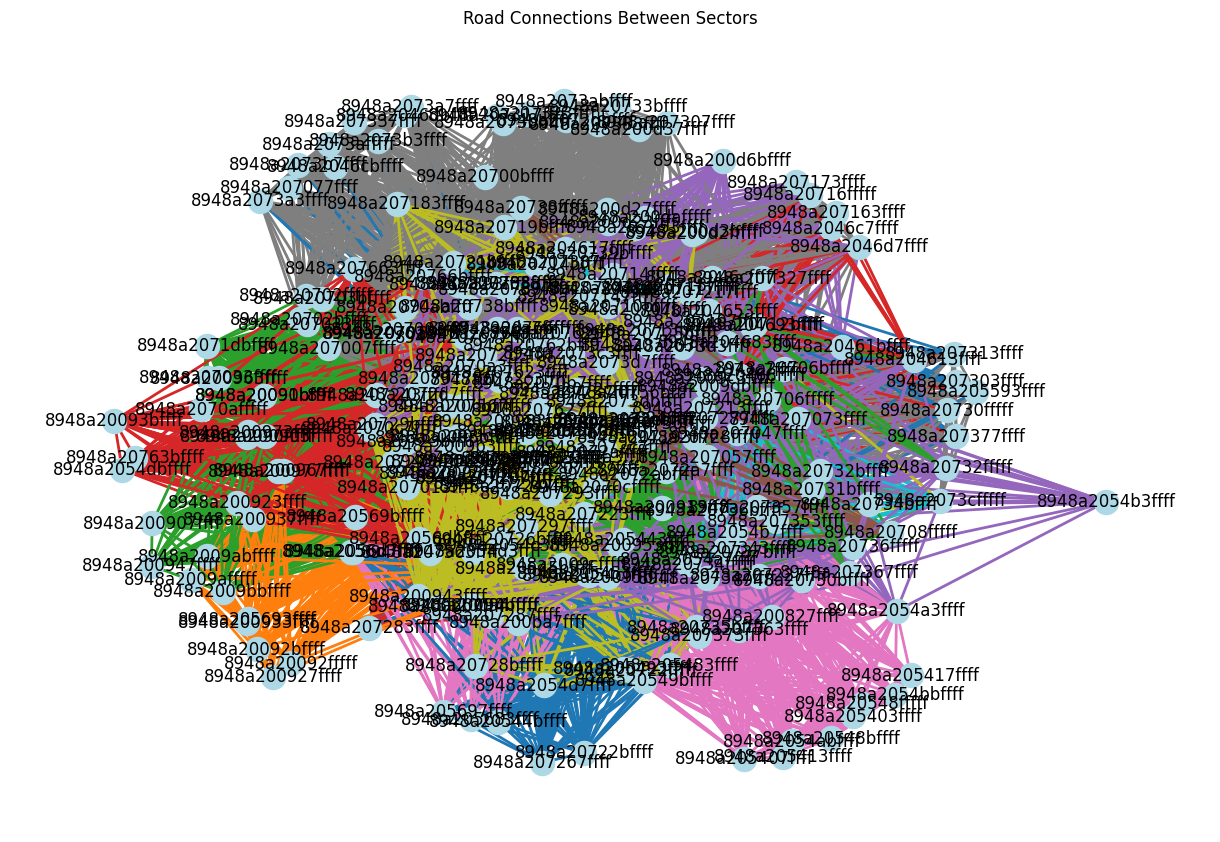

In [19]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import random

# Initialize the graph
G = nx.Graph()

# Create a color map
unique_colors = plt.cm.get_cmap('tab10', len(intersections_bysector_df))

# Iterate over each row in intersections_bysector_df to add edges
for idx, row in intersections_bysector_df.iterrows():
    road_name = row['vialidad']
    
    # Get sectors connected by this road (where intersection is 1)
    sectors_connected = [sector for sector, intersect in zip(sectors_workingarea_list, row[1:]) if intersect == 1]
    
    # Add edges between each pair of connected sectors for this road
    color = unique_colors(idx)  # Unique color for this road
    for sector1, sector2 in itertools.combinations(sectors_connected, 2):
        # Add edge with a color attribute for visualization
        G.add_edge(sector1, sector2, color=color, label=road_name)

# Plot the graph
pos = nx.spring_layout(G)  # Layout for better visualization
edges = G.edges(data=True)
edge_colors = [edge[2]['color'] for edge in edges]  # Extract edge colors

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color=edge_colors, width=2, edge_cmap=unique_colors)
plt.title("Road Connections Between Sectors")
plt.show()


In [20]:
import random

test_traslados = traslados_day0_keyonly.sample(10)

In [21]:
# Step 1: Build the graph with road connections from intersections_bysector_df
G = nx.Graph()

# Iterate over each row in intersections_bysector_df to add edges to the graph
for idx, row in intersections_bysector_df.iterrows():
    road_name = row['vialidad']
    
    # Get sectors connected by this road (where intersection is 1)
    sectors_connected = [sector for sector, intersect in zip(sectors_workingarea_list, row[1:]) if intersect == 1]
    
    # Add edges between each pair of connected sectors for this road
    for sector1, sector2 in itertools.combinations(sectors_connected, 2):
        G.add_edge(sector1, sector2, road=road_name)

# Step 2: Define a function to find a route and track road changes
def find_route(G, start_node, end_node):
    try:
        # Find shortest path based on nodes
        path = nx.shortest_path(G, source=start_node, target=end_node)
        
        # Track the road names used along the path
        route = []
        current_road = G.edges[path[0], path[1]]['road']
        segment = [path[0]]  # Initialize with the start node
        
        for i in range(1, len(path)):
            edge_road = G.edges[path[i-1], path[i]]['road']
            if edge_road != current_road:
                # Add the completed segment to the route
                segment.append(path[i-1])
                route.append((current_road, segment))
                
                # Start a new segment on a different road
                current_road = edge_road
                segment = [path[i-1]]
                
            segment.append(path[i])
        
        # Add the final segment to the route
        route.append((current_road, segment))
        
        return route
    
    except nx.NetworkXNoPath:
        return f"No route found from {start_node} to {end_node}."

# Step 3: Loop over test_traslados and calculate routes
for idx, traslado in test_traslados.iterrows():
    origin_sector = traslado['h3_origin']
    destination_sector = traslado['h3_destination']

    if origin_sector not in G.nodes or destination_sector not in G.nodes:
        print(f"No route found from {origin_sector} to {destination_sector}.")
        print("\n")
        continue
    
    # Find the route between origin and destination
    route = find_route(G, origin_sector, destination_sector)
    
    # Display the route for each traslado
    print(f"Route from {origin_sector} to {destination_sector}:")
    if isinstance(route, str):  # If no route found, route is a string
        print(route)
    else:
        for road, segment in route:
            print(f"{road}: {' - '.join(segment)}")
    print("\n")


Route from 8948a2054dbffff to 8948a2072b3ffff:
202: 8948a2054dbffff - 8948a2072cfffff - 8948a2072cfffff
70C: 8948a2072cfffff - 8948a2072b3ffff


Route from 8948a207247ffff to 8948a2073d3ffff:
73Z: 8948a207247ffff - 8948a2073d3ffff


Route from 8948a20704fffff to 8948a207043ffff:
77: 8948a20704fffff - 8948a207043ffff


Route from 8948a2072a3ffff to 8948a2072abffff:
77: 8948a2072a3ffff - 8948a2072abffff


Route from 8948a207147ffff to 8948a207387ffff:
70V: 8948a207147ffff - 8948a207387ffff


Route from 8948a2073cbffff to 8948a207053ffff:
69: 8948a2073cbffff - 8948a207053ffff


Route from 8948a207233ffff to 8948a207207ffff:
86: 8948a207233ffff - 8948a207207ffff


Route from 8948a20702bffff to 8948a20703bffff:
46: 8948a20702bffff - 8948a20703bffff


Route from 8948a207393ffff to 8948a20714bffff:
46: 8948a207393ffff - 8948a20714bffff


No route found from 8948a207177ffff to 8948a207173ffff.




In [22]:
# Export the graph to a GEXF file
nx.write_gexf(G, "red_transporte-publico.gexf")

In [23]:
vialidades = gpd.read_file('data_transporte_inside.geojson')

In [25]:
# Get lists of route names and road names
route_names = transporte['nombre'].tolist()
road_names = vialidades['nombre'].tolist()

# Initialize an empty DataFrame with route names as rows and road names as columns
binary_df = pd.DataFrame(0, index=route_names, columns=road_names)

# Iterate over each route in 'transporte'
for _, route in transporte.iterrows():
    route_name = route['nombre']
    route_geom = route['geometry']
    
    # Iterate over each road in 'vialidades'
    for _, road in vialidades.iterrows():
        road_name = road['nombre']
        road_geom = road['geometry']
        
        # Check if the route intersects the road
        if route_geom.intersects(road_geom):
            # Set the corresponding cell to 1 if there's an intersection
            binary_df.at[route_name, road_name] = 1

In [26]:
binary_df.head()

,Av. Churubusco,Av. Alfonso Reyes,Av. Prolongación Madero,Av. Constitución,Av. Francisco I. Madero,Av. Cristóbal Colón,Cuauhtémoc,Av. Dr. Ignacio Morones Prieto,Fundidora,Av. José María Luis Mora,...,Thomas Alva Edison,Nevado De Toluca,Licenciado José Benítez,Belisario Domínguez,Francisco Garza Sada,Héroes Del 47,Céntrica,Manuel Doblado Norte,Av. José María Luis Mora,Luis Quintanar
220VSF,0,1,0,0,1,1,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0
116SV,0,0,0,0,1,1,0,0,0,1,...,0,0,0,0,0,1,0,1,1,0
226,1,1,1,0,1,1,1,0,1,1,...,0,0,0,0,0,1,0,0,1,0
134F,0,0,0,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
328,0,0,0,1,1,1,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0


In [27]:
# Export the DataFrame to a CSV file
binary_df.to_csv("intersections_route_x_road.csv")